In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [17]:
tesla = pd.read_csv('TSLA.csv')

In [18]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [19]:
#Isolating the date and close price
tesla = tesla[['Date', 'Close']]

In [20]:
tesla.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [21]:
#converting date series to a datetime object
tesla.Date = pd.to_datetime(tesla.Date, format = "%Y/%m/%d")

In [22]:
#setting the index
plot_tesla = tesla.set_index('Date')

Plot of the Tesla stock price dataset

<AxesSubplot: xlabel='Date'>

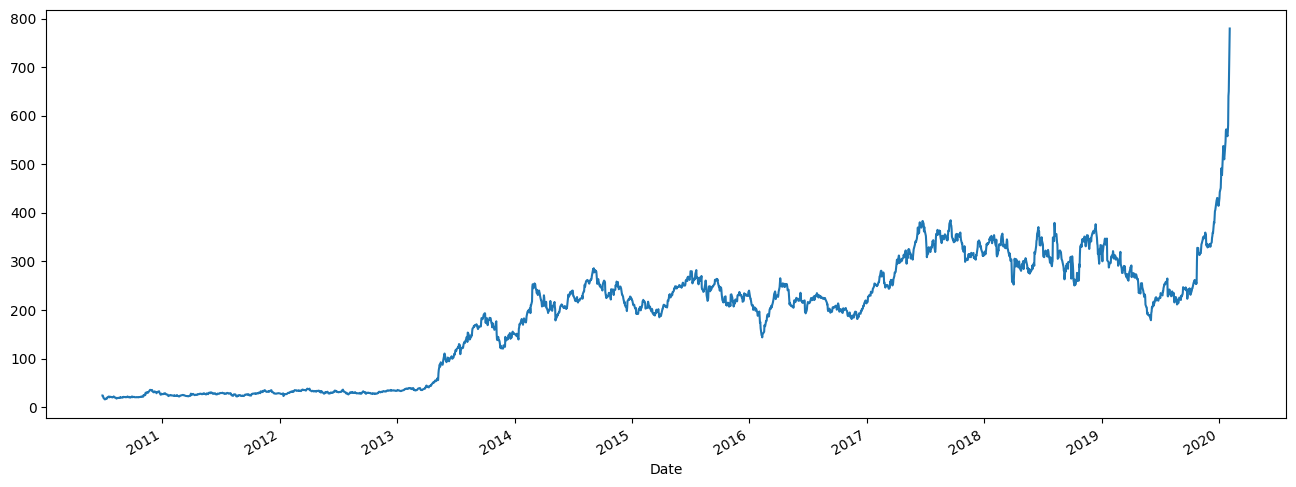

In [24]:
plot_tesla['Close'].plot(figsize = (16,6))

**Data Preprocessing**

Upon visual inspection, the time series is roughly stationary from the period of 2014 through the end of 2016, so let's reduce the dataset to 2014 through 2016. Stationarity means that the time series has a constant mean and variance over a certain time horizon.

Start date: 1/1/14 -> index = 884

End date: 12/31/16 -> index = 1639

In [25]:
new_tesla = tesla.loc[884:1639]

In [26]:
new_tesla.head()

,Date,Close
884,2014-01-02,150.100006
885,2014-01-03,149.559998
886,2014-01-06,147.000000
887,2014-01-07,149.360001
888,2014-01-08,151.279999


In [27]:
new_tesla.tail()

,Date,Close
1635,2016-12-23,213.339996
1636,2016-12-27,219.529999
1637,2016-12-28,219.740005
1638,2016-12-29,214.679993
1639,2016-12-30,213.690002


**min_max scaling and train/test splitting**

In [29]:
new_tesla = new_tesla.drop('Date', axis = 1)
new_tesla = new_tesla.reset_index(drop=True)
new_tesla.head()

,Close
0,150.100006
1,149.559998
2,147.000000
3,149.360001
4,151.279999


In [32]:
T = new_tesla.values
T = T.astype('float32')
T = np.reshape(T, (-1,1))

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
T = scaler.fit_transform(T)

#80:20 split
train_size = int(len(T)* 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [37]:
#Method for creating features from the time series data

def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i : (i+window_size) , 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

#Assuming 5 trading days per week for 1 month
window_size = 20
x_train, y_train = create_features(train, window_size)

x_test, y_test = create_features(test, window_size)

#Reshape to the format of [samples, timestamps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [39]:
#Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

#Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

isLeak(T_shape, train_shape, test_shape)

False

In [43]:
#Model imports

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint


**Building the LSTM RNN Model**

Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [47]:
#building model

model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', input_shape = (x_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [54]:
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                            monitor = 'val_loss',
                            verbose = 1,
                            save_best_only = True,
                            mode = 'min')

history = model.fit(x_train, y_train, 
                    epochs = 100, batch_size = 20, 
                    validation_data = (x_test, y_test),
                    callbacks = [checkpoint],
                    verbose = 1, shuffle = False)

model.summary()

Epoch 1/100
29/30 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 1: val_loss improved from inf to 0.00084, saving model to saved_models\model_epoch_01.hdf5
30/30 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 8.4233e-04
Epoch 2/100
23/30 [======================>.......] - ETA: 0s - loss: 0.0032
Epoch 2: val_loss improved from 0.00084 to 0.00080, saving model to saved_models\model_epoch_02.hdf5
30/30 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 8.0004e-04
Epoch 3/100
22/30 [=====================>........] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss improved from 0.00080 to 0.00079, saving model to saved_models\model_epoch_03.hdf5
30/30 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 7.9028e-04
Epoch 4/100
25/30 [========================>.....] - ETA: 0s - loss: 0.0035
Epoch 4: val_loss did not improve from 0.00079
30/30 [==============================] - 0s 7ms/step - loss: 0.0037 - val_los

The model at epoch 92 had the most similar training and validation losses, which implies that the model is not doing a lot of over or under fitting. As such, we load that model.

In [56]:
from keras.models import load_model

best_model = load_model('saved_models/model_epoch_92.hdf5')

#Predicting and inverse transforming the predictions

train_predict = best_model.predict(x_train)

y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(x_test)

y_hat_test = scaler.inverse_transform(test_predict)

#Inverse transforming the actua values, to return them to their original values
y_test = scaler.inverse_transform([y_test])
y_train = scaler.inverse_transform([y_train])

5/5 [==============================] - 0s 4ms/step


In [57]:
y_hat_train = np.reshape(y_hat_train, newshape = 583)
y_hat_test = np.reshape(y_hat_test, newshape = 131)

y_train = np.reshape(y_train, newshape = 583)
y_test = np.reshape(y_test, newshape = 131)

**Evaluating Model Performance**

Computing the RMSE for the training and testing sets

In [58]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))

test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print('Train RMSE is: ')
print(train_rmse, '\n')
print('Test RMSE is: ')
print(test_rmse)

Train RMSE is: 
0.041753142043696366 

Test RMSE is: 
0.026724129508284122


**Visualizing the actual vs. predicted stock prices**

In [59]:
y = np.append(y_train, y_test)
y_hat = np.append(y_hat_train, y_hat_test)


In [60]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = y
result_df['Predicted_Y'] = y_hat

result_df.head()

,Actual_Y,Predicted_Y
0,0.286776,0.316245
1,0.257464,0.307284
2,0.268507,0.304133
3,0.239127,0.294274
4,0.266121,0.286206


<AxesSubplot: >

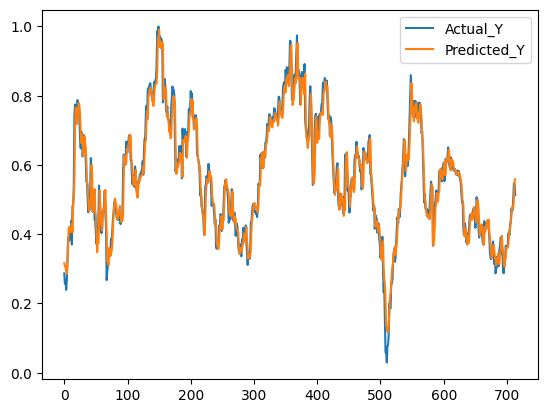

In [61]:
result_df.plot()